<a href="https://colab.research.google.com/github/ebzkurt1/ml_from_scratch/blob/main/Perceptron_using_Jax_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Single Node Multi-Class Perceptron Algorithm

This code contains simple single node multi-class perceptron algorithm for classifying the MNIST data. The algorithm uses the JAX library for operations such as matrix multiplication and gradient calculation.

For the model Softmax activation function is used along with Categorical Cross Entropy loss function. The gradients of the weights and biases are directly calculated using the `grad()` function of the JAX library

This project aims to help understand the underlying mathematical calculations and step-by-step implementation of the model from scractch using automatic differentiation.

Final model accuracies are not high, as expected, since the model used is not complex.

In [1]:
import numpy as np
import jax
from jax import random
import jax.numpy as jnp
from jax import grad, jit, vmap
import matplotlib.pyplot as plt

## Functional Perceptron

First of to try out the implementation itself the Perceptron is generated using functions without a class. This model is tested on a random data generated using the `sklearn.datasets.make_blobs` library. The random data has 1000 samples, 10 features and 3 different classes. The generated data is then turned into JAX DeviceArray objects.

In [6]:
from sklearn.datasets import make_blobs
# Generating data for the model
X, y = make_blobs(n_samples=1000,n_features=10, centers=3)
# Transforming the data into JAX object
X = jnp.asarray(X)
y = jnp.asarray(y).reshape(-1,1)
# Generating the Gaussian Random Weight and Bias of the model
W = random.normal(
    key=random.PRNGKey(42), # Random key of the weight
    shape=(X.shape[-1],np.unique(y).shape[0]) # Shape of the weight
)
b = random.normal(
    key=random.PRNGKey(42),
    shape=(np.unique(y).shape[0],1)
)
# Normalizing the data generated by subtracting the mean and dividing the std
X = (X - jnp.mean(X,axis=1).reshape(-1,1))/jnp.std(X,axis=1).reshape(-1,1)

### Generating the model

Each part of the model is generated using custom functions. These functions include activation, loss, and feed forward functions.

After constructing the functions the model is fitted using 1000 epochs.

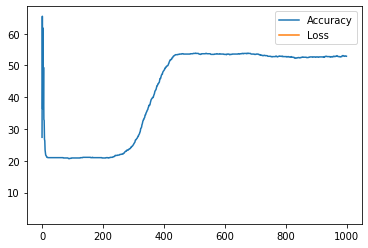

In [7]:
def custom_softmax(matrix):
    """
    Custom Softmax function for the activation process
    """
    matrix = matrix - jnp.sum(matrix,axis=1).reshape(-1,1)
    return jnp.exp(matrix)/jnp.sum(jnp.exp(matrix),axis=1).reshape(-1,1)

def forward_pass(X, W, b, activation):
    """
    The forward pass process. First matrix multiplication is calculated and then
    the given activation function is applied.
    """
    mm = (jnp.matmul(X, W).T + b).T
    return activation(mm)

def categorical_cross_entropy(yhat,y):
    """
    Custom Categorical Cross Entropy function as the loss
    """
    return -jnp.sum(y*jnp.log(yhat))/y.shape[0]

def loss(X,Y,W,b,loss_fnc, activation):
    """
    Calculating the loss by first applying the feed forward and then using the
    given loss function.
    """
    Yhat = forward_pass(X,W,b,activation)
    return loss_fnc(Yhat,Y)

acc = [] # Empty list for storing epoch accuracies
lss_list = [] # Empty list for storing epoch losses
for i in range(1000): # Iterating through the epochs
    # Forward pass
    fwd = forward_pass(X,W,b,custom_softmax)
    # Making prediction
    prd = (jnp.argmax(fwd,axis=1)).reshape(-1,1)
    # Calculating the loss
    lss = categorical_cross_entropy(fwd,y)
    # Acquiring accuracy for this epoch
    step_accuracy = (((prd==y).sum())/X.shape[0])*100
    acc.append(step_accuracy)
    lss_list.append(lss)
    # Taking the gradient of the loss function w.r.t. weights
    W_grad = grad(loss,argnums=2)(X,y,W,b,categorical_cross_entropy,custom_softmax)
    # Taking the gradient of the loss function w.r.t. bias
    b_grad = grad(loss,argnums=3)(X,y,W,b,categorical_cross_entropy,custom_softmax)
    # Updating the weights and the biases
    W -= 0.2*W_grad
    b -= 0.2*b_grad
# Plotting the result
plt.plot(acc)
plt.plot(lss)
plt.legend(["Accuracy","Loss"])

## Perceptron Class Model

The Perceptron model is written as a Class for better usage and implementation. The functions and the main idea is the same as the functional example. However this model can be implemented and used with different parameters and different data with ease.

In [14]:
class Perceptron:
    def __init__(self, class_num=1, activation_func='sigmoid', loss_func='mean_squared_error', learning_rate=0.1, iter=50, random_key=1):
        self.class_num = class_num
        self.activation_func = activation_func
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.iter = iter
        self.random_key = random.PRNGKey(random_key)

    def initialize_weights(self, X):
        self.W = random.normal(
            key=self.random_key,
            shape=(X.shape[-1],self.class_num)
        )
        self.b = random.normal(
            key=self.random_key,
            shape=(self.class_num,1)
        )

    def forward(self, X):
        return (jnp.matmul(X, self.W).T + self.b).T

    def softmax_func(self, matrix):
        matrix = matrix - jnp.max(matrix,axis=1).reshape(-1,1)
        return jnp.exp(matrix)/jnp.sum(jnp.exp(matrix),axis=1).reshape(-1,1)

    def sigmoid_func(self, matrix):
        return (1/(1+jnp.exp(-matrix)))

    def jax_sigmoid(self, matrix):
        return jax.nn.sigmoid(matrix)
    
    def mean_squared_error(self, Yhat, Y):
        return jnp.mean((Yhat-Y)**2)
        
    def categorical_cross_entropy(self, Yhat, Y):
        return -jnp.sum(Y*jnp.log(Yhat))/Y.shape[0]
    
    def forward_step(self, X, W, b):
        mm = (jnp.matmul(X, W).T + b).T
        if self.activation_func == 'sigmoid':
            return self.sigmoid_func(mm)
        elif self.activation_func == 'softmax':
            return self.softmax_func(mm)
        else:
            return mm
    
    def loss(self, X, Y, W, b):
        Yhat = self.forward_step(X,W,b)
        if self.loss_func == 'mean_squared_error':
            return self.mean_squared_error(Yhat, Y)
        elif self.loss_func == 'categorical_cross_entropy':
            return self.categorical_cross_entropy(Yhat,Y)

    def param_update(self, w_gradient, b_gradient):
        self.W -= self.learning_rate * w_gradient
        self.b -= self.learning_rate * b_gradient
    
    def predict(self, X):
        return jnp.argmax(self.forward_step(X,self.W,self.b),axis=1).reshape(-1,1)

    def fit(self, X, Y):
        self.history = {
            'loss':[],
            'accuracy':[]
        }
        self.initialize_weights(X)
        for i in range(self.iter):
            fwd = self.forward_step(X,self.W,self.b)
            step_prediction = self.predict(X).reshape(-1,1)
            step_accuracy = (((step_prediction==Y).sum())/X.shape[0])*100
            step_loss = self.loss(X, Y, self.W, self.b)
            self.history['accuracy'].append(step_accuracy)
            self.history['loss'].append(step_loss)
            W_grad = grad(self.loss,argnums=2)(X,Y,self.W,self.b)
            b_grad = grad(self.loss,argnums=3)(X,Y,self.W,self.b)
            self.param_update(W_grad,b_grad)
            # print("Epoch",i,"accuracy :",step_accuracy)
        return self.history

### Loading and prepearing the data

To test the model MNIST data is loaded from the `keras.datasets.mnist` library. Both the train and test data can be directly acquired using `mnist.load_data()` function. 

Then the loaded data can be flattened and normalized for the model.

In [15]:
from keras.datasets import mnist
# Loading the data
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()

In [16]:
print("Train X shapes : ", train_X.shape, type(train_X))
print("Train Y shapes : ", train_Y.shape, type(train_Y))
print("Test X shapes : ", test_X.shape, type(test_X))
print("Test Y shapes : ", test_Y.shape, type(test_Y))

# Processing the Train data
flat_train_X = jnp.asarray(train_X).reshape(-1,28*28)
flat_norm_train_X = flat_train_X/255.0
flat_train_Y = jnp.asarray(train_Y).reshape(-1,1)

# Processing the test data
flat_test_X = jnp.asarray(test_X).reshape(-1,28*28)
flat_norm_test_X = flat_test_X/255.0
flat_test_Y = jnp.asarray(test_Y).reshape(-1,1)

print("Processed Train X shapes : ", flat_norm_train_X.shape, type(flat_norm_train_X))
print("Processed Train Y shapes : ", flat_train_Y.shape, type(flat_train_Y))
print("Processed Test X shapes : ", flat_norm_test_X.shape, type(flat_norm_test_X))
print("Processed Test Y shapes : ", flat_test_Y.shape, type(flat_test_Y))

Train X shapes :  (60000, 28, 28) <class 'numpy.ndarray'>
Train Y shapes :  (60000,) <class 'numpy.ndarray'>
Test X shapes :  (10000, 28, 28) <class 'numpy.ndarray'>
Test Y shapes :  (10000,) <class 'numpy.ndarray'>
Processed Train X shapes :  (60000, 784) <class 'jaxlib.xla_extension.DeviceArray'>
Processed Train Y shapes :  (60000, 1) <class 'jaxlib.xla_extension.DeviceArray'>
Processed Test X shapes :  (10000, 784) <class 'jaxlib.xla_extension.DeviceArray'>
Processed Test Y shapes :  (10000, 1) <class 'jaxlib.xla_extension.DeviceArray'>


In [17]:
# Generating the model
mnist_perceptron_model = Perceptron(
    class_num=10, # Number of classes in the dataset
    activation_func='softmax',
    loss_func='categorical_cross_entropy',
    iter=1000, # Epoch number
    learning_rate=0.0005 # Learning rate of the model
)

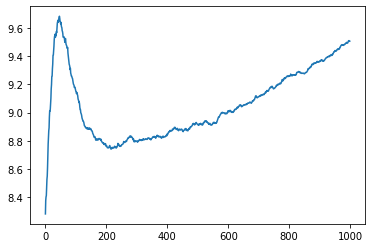

In [18]:
# Training the model on the data
mnist_history = mnist_perceptron_model.fit(flat_norm_train_X,flat_train_Y)
plt.plot(mnist_history['accuracy'])